# Hallo Zusammen!

Probe:  0 Ungefullte Flache:  61.013686326147024 Anzahl Hilfe-Säulen:  19 Anzahl Haupt-Säulen 84
Probe:  1 Ungefullte Flache:  2.8746050805584673 Anzahl Hilfe-Säulen:  5 Anzahl Haupt-Säulen 89
Probe:  2 Ungefullte Flache:  0.07196803281838075 Anzahl Hilfe-Säulen:  0 Anzahl Haupt-Säulen 89
OK
Ungefullte Flache:  0.07196803281838075
Prozent von eingefullte Flache:  99.99177508196362
Zu befüllender Bereich (m2): 875.0
Mindestanzahl von Säulen, um das gesamte Feld zu füllen:  89
Mindestanzahl von Haupt-Säulen, um das gesamte Feld zu füllen:  65
Mindestanzahl von Hilfe-Säulen, um das gesamte Feld zu füllen:  24


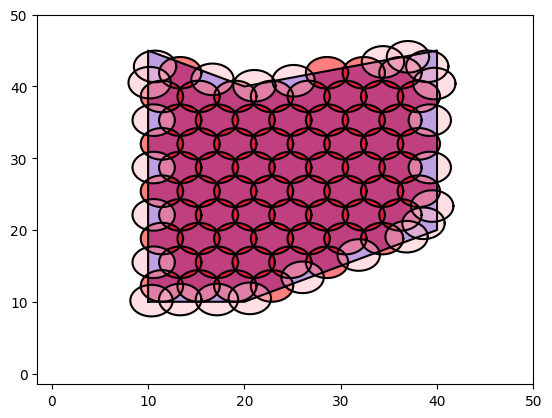

Koordinaten von Haupt-Säulen [<POINT (11.432 12.2)>, <POINT (15.242 12.2)>, <POINT (19.053 12.2)>, <POINT (22.863 12.2)>, <POINT (13.337 15.5)>, <POINT (17.147 15.5)>, <POINT (20.958 15.5)>, <POINT (24.768 15.5)>, <POINT (28.579 15.5)>, <POINT (11.432 18.8)>, <POINT (15.242 18.8)>, <POINT (19.053 18.8)>, <POINT (22.863 18.8)>, <POINT (26.674 18.8)>, <POINT (30.484 18.8)>, <POINT (34.295 18.8)>, <POINT (13.337 22.1)>, <POINT (17.147 22.1)>, <POINT (20.958 22.1)>, <POINT (24.768 22.1)>, <POINT (28.579 22.1)>, <POINT (32.389 22.1)>, <POINT (36.2 22.1)>, <POINT (11.432 25.4)>, <POINT (15.242 25.4)>, <POINT (19.053 25.4)>, <POINT (22.863 25.4)>, <POINT (26.674 25.4)>, <POINT (30.484 25.4)>, <POINT (34.295 25.4)>, <POINT (38.105 25.4)>, <POINT (13.337 28.7)>, <POINT (17.147 28.7)>, <POINT (20.958 28.7)>, <POINT (24.768 28.7)>, <POINT (28.579 28.7)>, <POINT (32.389 28.7)>, <POINT (36.2 28.7)>, <POINT (11.432 32)>, <POINT (15.242 32)>, <POINT (19.053 32)>, <POINT (22.863 32)>, <POINT (26.674 3

In [1]:
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from shapely.affinity import rotate
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import math
from shapely.ops import unary_union
import ast
import functools



def create_hexagon(centroid, hex_size):
    # Calculate the coordinates of the hexagon vertices
    angle = 2 * math.pi / 6
    vertices = []
    for i in range(6):
        x = centroid.x + hex_size * math.cos(i * angle)
        y = centroid.y + hex_size * math.sin(i * angle)
        vertices.append((x, y))

    # Create a Shapely Polygon
    hexagon = Polygon(vertices)
    hexagon = rotate(hexagon, angle=90, origin=centroid)
    return hexagon

def create_honeycomb(ax, rows, cols, hex_size, x_modyf, y_modyf):
    hexagon_centers = []
    for row in range(rows):
        for col in range(cols):
            x = col * hex_size * np.sqrt(3) + (row % 2) * hex_size * np.sqrt(3) / 2 + x_modyf
            y = row * hex_size * 1.5 + y_modyf
            #center = (x, y-1)
            #hexagon = RegularPolygon(center, numVertices=6, radius=hex_size, orientation=np.radians(0), edgecolor='black', facecolor='none')
            #ax.add_patch(hexagon)
            hexagon_centers.append((x, y-1))
    return hexagon_centers

def hexagon_centers_in_polygon(polygon, hexagon_centers):

    hexagon_centers_purged = []
    for center in hexagon_centers:
        if polygon.contains(Point(center)):
            hexagon_centers_purged.append(center)

    return hexagon_centers_purged

def plot_polygon(ax, polygons, color='blue', alpha=0.5):
    # Helper function to plot polygons
    for polygon in polygons:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=alpha)
        ax.plot(x, y, color='black')

#Beispierl INPUT
# (10, 10), (20, 10), (40, 20), (40, 45), (20, 40), (10, 45)
#radius_phase1 = 1.2
#radius_phase2 = 0.8

#INPUT

xy_coordinates = ast.literal_eval(input("Enter a list of points. For example (0,0), (0,1), (1,1), (1,0)"))

radius_phase1 = float(input("Radius für Hauptsäule, z.B 2.2"))
radius_phase2 = float(input("Radius für Hilfsäule, z.B 1.2"))

x_modyf = 0
y_modyf = 0

# First phase
fig, ax = plt.subplots()

polygon = Polygon(xy_coordinates)

hexagon_centers=create_honeycomb(ax, rows=100, cols=100, hex_size = radius_phase1,x_modyf = x_modyf, y_modyf = y_modyf)

hexagon_centers_inn = hexagon_centers_in_polygon(polygon, hexagon_centers)

hexagon_centers_inn = [Point(x, y) for x, y in hexagon_centers_inn]

circle_list_p1 = [point.buffer(radius_phase1) for point in hexagon_centers_inn]

# Second phase
def process_polygons(polygon, circle_list):
    hexagons_union = unary_union(circle_list)
    uncovered_polygon = polygon.difference(hexagons_union)

    uncovered_polygons = [geom for geom in uncovered_polygon.geoms]
    uncovered_polygons = [poly for poly in uncovered_polygons if poly.area > 0.1]
    uncovered_polygon_centers = [geom.centroid for geom in uncovered_polygons]

    circle_list_out = [point.buffer(radius_phase1) for point in uncovered_polygon_centers]

    return circle_list_out,uncovered_polygon,uncovered_polygon_centers

total_circle_list = circle_list_p1
circle_list_p2 = []
circle_centerpoint_list_p2 = []


for i in range(5):
    circle_list_out,uncovered_polygon , hilfe_circle_center = process_polygons(polygon, total_circle_list)
    total_circle_list = total_circle_list + circle_list_out
    circle_list_p2 += circle_list_out
    circle_centerpoint_list_p2 += hilfe_circle_center
    print("Probe: ",i , "Ungefullte Flache: ", uncovered_polygon.area ,"Anzahl Hilfe-Säulen: ", len(circle_list_out) ,"Anzahl Haupt-Säulen", len(total_circle_list))
    if len(circle_list_out) == 0:
        uncovered_polygon_out = uncovered_polygon
        break
    else:
        continue

#Raport
print("OK" if uncovered_polygon_out.area < 1 else "Es gibt noch viele ungefüllte Bereiche!")
print("Ungefullte Flache: ", uncovered_polygon_out.area)
print("Prozent von eingefullte Flache: ", (1 - uncovered_polygon_out.area/polygon.area)*100)
print("Zu befüllender Bereich (m2):",polygon.area)
print("Mindestanzahl von Säulen, um das gesamte Feld zu füllen: ", len(total_circle_list))
print("Mindestanzahl von Haupt-Säulen, um das gesamte Feld zu füllen: ", len(circle_list_p1))
print("Mindestanzahl von Hilfe-Säulen, um das gesamte Feld zu füllen: ", len(circle_list_p2))

#Plotting
plot_polygon(ax, [polygon])
plot_polygon(ax, circle_list_p1, color='red', alpha=0.5)
plot_polygon(ax, circle_list_p2, color='pink', alpha=0.5)
#plot_polygon(ax, circle_list_out_p3, color='orange', alpha=0.5)
ax.set_xlim(-1.5, 50)
ax.set_ylim(-1.5, 50)

plt.show()

#print("Koordinaten von Haupt-Säulen",hexagon_centers_inn)
print("Koordinaten von Hilfe-Säulen",circle_centerpoint_list_p2)


## **Erwrtete Ergebniss**

Enter a list of points. For example (0,0), (0,1), (1,1), (1,0)(10, 10), (20, 10), (40, 20), (40, 45), (20, 40), (10, 45)
Radius für Hauptsäule, z.B 2.22.0
Radius für Hilfsäule, z.B 1.21.5
Probe:  0 Ungefullte Flache:  17.541370935427178 Anzahl Hilfe-Säulen:  11 Anzahl Haupt-Säulen 100
Probe:  1 Ungefullte Flache:  0.4460037560449602 Anzahl Hilfe-Säulen:  0 Anzahl Haupt-Säulen 100
OK
Ungefullte Flache:  0.4460037560449602
Prozent von eingefullte Flache:  99.94902814216628
Zu befüllender Bereich (m2): 875.0
Mindestanzahl von Säulen, um das gesamte Feld zu füllen:  100
Mindestanzahl von Haupt-Säulen, um das gesamte Feld zu füllen:  89
Mindestanzahl von Hilfe-Säulen, um das gesamte Feld zu füllen:  11
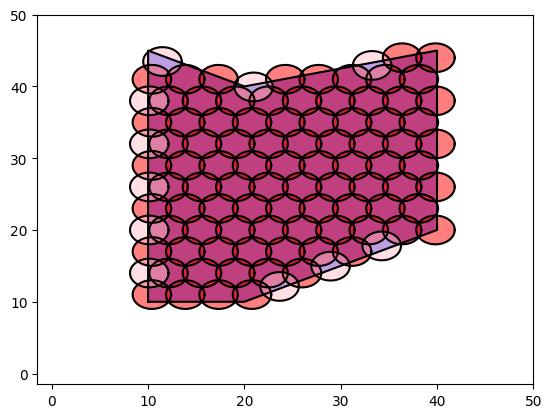

Koordinaten von Haupt-Säulen [<POINT (10.392 11)>, <POINT (13.856 11)>, <POINT (17.321 11)>, <POINT (20.785 11)>, <POINT (12.124 14)>, <POINT (15.588 14)>, <POINT (19.053 14)>, <POINT (22.517 14)>, <POINT (25.981 14)>, <POINT (10.392 17)>, <POINT (13.856 17)>, <POINT (17.321 17)>, <POINT (20.785 17)>, <POINT (24.249 17)>, <POINT (27.713 17)>, <POINT (31.177 17)>, <POINT (12.124 20)>, <POINT (15.588 20)>, <POINT (19.053 20)>, <POINT (22.517 20)>, <POINT (25.981 20)>, <POINT (29.445 20)>, <POINT (32.909 20)>, <POINT (36.373 20)>, <POINT (39.837 20)>, <POINT (10.392 23)>, <POINT (13.856 23)>, <POINT (17.321 23)>, <POINT (20.785 23)>, <POINT (24.249 23)>, <POINT (27.713 23)>, <POINT (31.177 23)>, <POINT (34.641 23)>, <POINT (38.105 23)>, <POINT (12.124 26)>, <POINT (15.588 26)>, .....
Koordinaten von Hilfe-Säulen [<POINT (23.654 12.133)>, <POINT (28.944 14.959)>, <POINT (34.255 17.779)>, <POINT (33.264 42.928)>, <POINT (20.958 39.934)>, <POINT (11.492 43.474)>, <POINT (10.121 38)>, <POINT (10.121 32)>, <POINT (10.121 26)>, <POINT (10.121 20)>, <POINT (10.121 14)>]